## Clustering

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("hw1_dataset.csv")


In [3]:
# As always split dataset
df_desc = df.iloc[:, 11:]
df_info = df.iloc[:, :11]


We have to perform tSNE to reduce number of variables

In [4]:
# perform t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_df = tsne.fit_transform(df_desc)
tsne_df = pd.DataFrame(tsne_df, columns=["tsne1", "tsne2"])


To choose clustering algorithm we should remember that our dataset is quite large, we don't know number of clusters, so the best algorithm can be BIRCH. Let's check it's performance. 

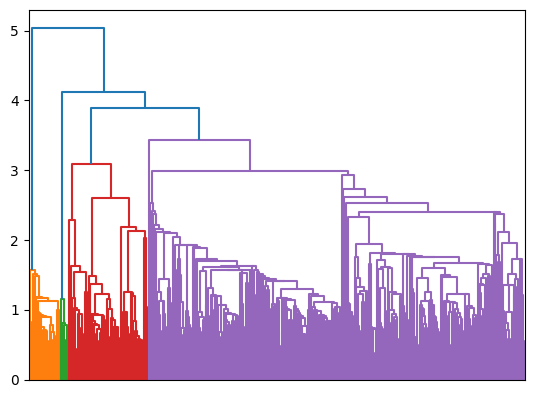

In [5]:
Z = hierarchy.linkage(tsne_df, 'single')
hierarchy.dendrogram(Z)
plt.xticks([])
plt.show()

By using hierarchical algorithm we can see that there are 3 main clusters and 1 small cluster. Now we can use BIRCH with 4 clusters.

<AxesSubplot: xlabel='tsne1', ylabel='tsne2'>

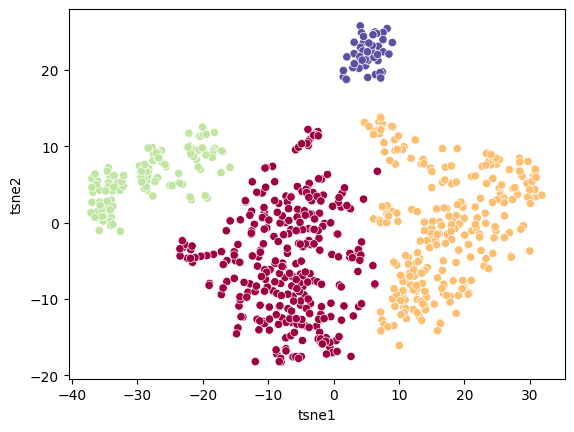

In [6]:
model = Birch(n_clusters = 4, branching_factor = 60, threshold = 0.5)
model.fit(tsne_df)
pred = model.predict(tsne_df)
sns.scatterplot(tsne_df, x = "tsne1", y = "tsne2", c = pred, cmap="Spectral")

We can see that BIRCH is quite good with predicting the clusters, we can also visualize our results with clustermap

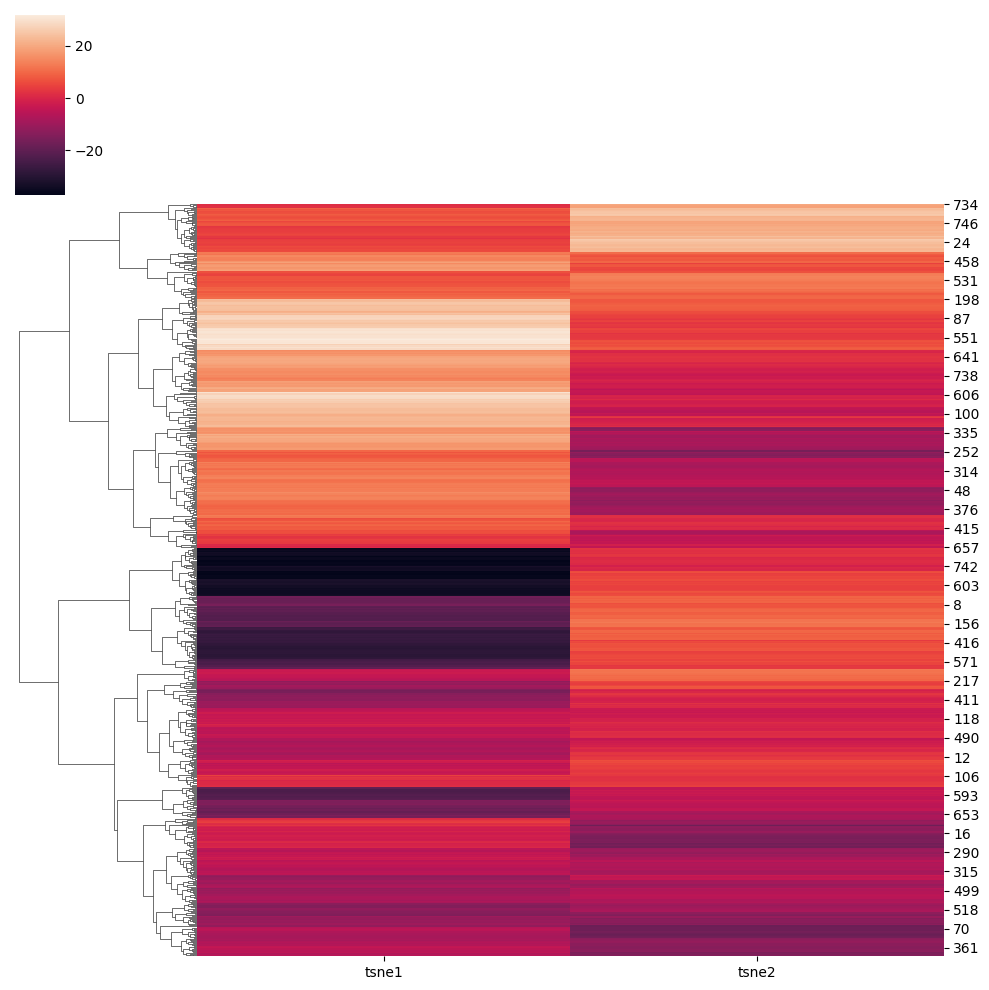

In [7]:
sns.clustermap(tsne_df, col_cluster = False)

Here we can see that there are 3 big clusters and one small cluster if you look at tsne1 and that there are barely 2-3 clusters if you look at tsne 2. These results are very similar to BIRCH

In [8]:
df['cluster'] = pred

Now we can plot how different parameters depend on a class

<AxesSubplot: xlabel='cluster', ylabel='SLogP'>

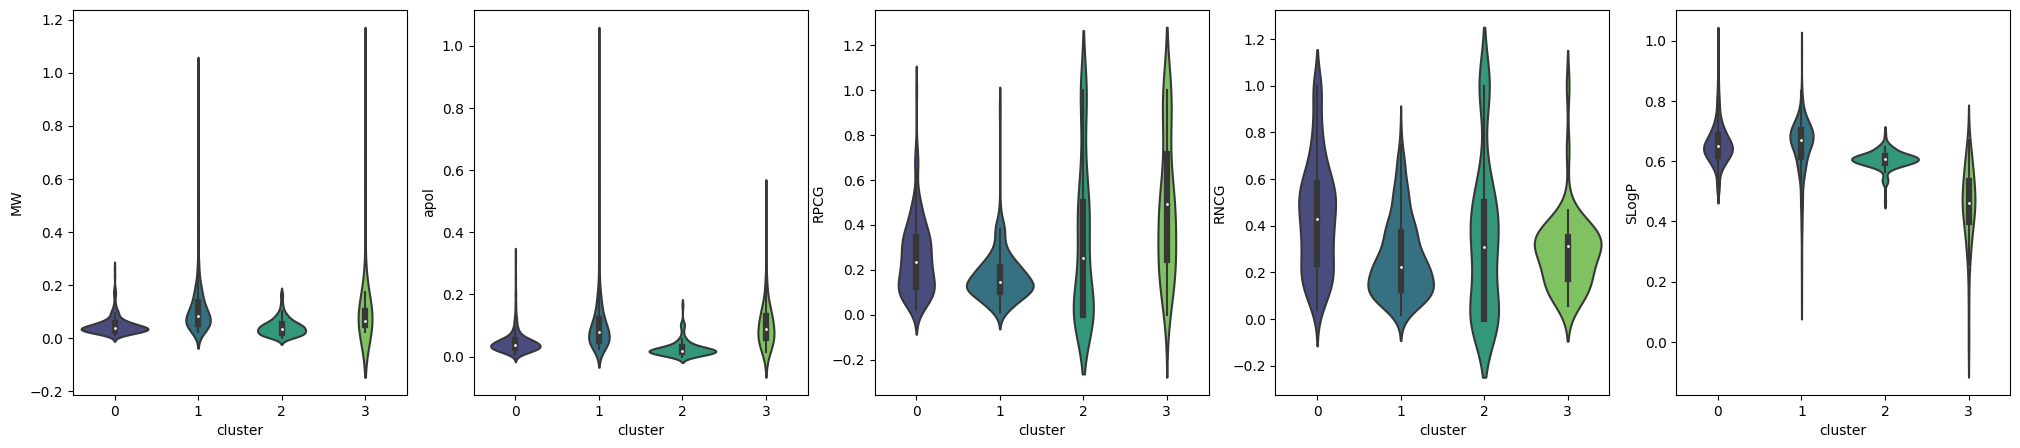

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

sns.violinplot(ax=axes[0], data=df, x="cluster", y="MW", palette="viridis")
sns.violinplot(ax=axes[1], data=df, x="cluster", y="apol", palette="viridis")
sns.violinplot(ax=axes[2], data=df, x="cluster", y="RPCG", palette="viridis")
sns.violinplot(ax=axes[3], data=df, x="cluster", y="RNCG", palette="viridis")
sns.violinplot(ax=axes[4], data=df, x="cluster", y="SLogP", palette="viridis")

We can see that classes are clearly separated for all values: molecular weight, atomic polarizability, relative positive charge, relative negative charge and Wildman-Crippen LogP


## Feature Engineering

In [10]:
from autofeat.autofeat import AutoFeatRegressor


We will use AutoFeatRegressor for feature engineering, this can be done by creating a regression model. We will predict raw value based on a selected descriptors

In [11]:
interesting_columns = [
    "MW",
    "Radius",
    "apol",
    "RNCG",
    "RPCG",
    "BalabanJ",
    "nH",
    "nAtom",
    "SLogP",
    "nAcid",
    "nBase",
    "HeavyAtomCount",
]


In [36]:
X = df[interesting_columns]
Y = df['value_from']

In [13]:
model = AutoFeatRegressor(
    apply_pi_theorem=True,
    categorical_cols=None,
    feateng_cols=None,
    feateng_steps=2,
    featsel_runs=3,
    transformations=("exp", "log", "abs", "sqrt", "^2", "^3", "1/"),
)


In [14]:
X_feature_creation = model.fit_transform(X, Y)

In [15]:
X_feature_creation.columns

Index(['MW', 'Radius', 'apol', 'RNCG', 'RPCG', 'BalabanJ', 'nH', 'nAtom',
       'SLogP', 'nAcid', 'nBase', 'HeavyAtomCount', 'SLogP*exp(nAcid)',
       'sqrt(RNCG)*exp(BalabanJ)', 'sqrt(BalabanJ)*sqrt(Radius)',
       'BalabanJ**3*nH**2', 'BalabanJ*sqrt(RNCG)', 'Radius**3*sqrt(nAcid)'],
      dtype='object')

Out of these features the most interesting one is Radius**2*sqrt(nAcid), because it has to do something with the surface area and number of acidic atoms, these parameters do seem to have some connection.

## Feature Selection

For feature selection we will first try genetic selection

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
from genetic_selection import GeneticSelectionCV


In [65]:
gbr = GradientBoostingRegressor()


In [66]:
model = GeneticSelectionCV(
    gbr,
    cv=5,
    verbose=0,
    scoring="r2",
    max_features=5,
    n_population=5,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=20,
    caching=True,
    n_jobs=-1,
)

model = model.fit(X, Y)


In [67]:
print("Features:", X.columns[model.support_])


Features: Index(['apol', 'nAtom', 'nAcid', 'HeavyAtomCount'], dtype='object')


We can also try froward feature selection

In [68]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs

sfs = sfs(gbr, n_features_to_select=5, scoring="r2", cv=5)

# Perform SFFS
sfs = sfs.fit(X, Y)


In [69]:
print("Features:", X.columns[sfs.support_])


Features: Index(['Radius', 'apol', 'BalabanJ', 'nBase', 'HeavyAtomCount'], dtype='object')


Another possible method is recursive feature elimination

In [70]:
from sklearn.feature_selection import RFE

selector = RFE(gbr, n_features_to_select=5, step=1)
selector = selector.fit(X, Y)


In [71]:
selector.get_feature_names_out()


array(['MW', 'apol', 'RNCG', 'SLogP', 'HeavyAtomCount'], dtype=object)

From all of these methods the most important features are atomic polarizability and heavy atom count